In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from xgboost import XGBRegressor
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
import shap

In [87]:
# Read in formatted dataset
# assume repo root is two levels up from this notebook
ROOT = Path.cwd().parents[1]  # adjust if needed
DATA_DIR = ROOT / "data"

print(DATA_DIR)

print(ROOT)

df = pd.read_parquet(
    DATA_DIR / "processed_pitches_df_2023-03-30_2025-09-30.parquet"
)


/Users/matthewgillies/PitchArsenalModelling/data
/Users/matthewgillies/PitchArsenalModelling


In [88]:
df.head()

,pitcher,pitch_type,season,pitches,whiff_pct,csw_pct,p_throws,velo,VAA,HAA,...,delta_ext_vs_fb,delta_spin_vs_fb,delta_rel_x_vs_fb,delta_rel_z_vs_fb,movdist_vs_fb,shape_dist_vs_fb,second_pitch_usage,max_other_usage,min_movdist_to_other,min_shape_dist_to_other
0,425794,CH,2023,89,0.100000,0.134831,R,81.431461,-4.546824,0.9675,...,-0.040449,-511.878277,-0.0511,0.007877,2.528497,11.176841,0.305882,0.313725,2.528497,11.176841
1,425794,CU,2023,546,0.149378,0.252747,R,71.506044,-4.591665,1.387363,...,-0.228346,480.850866,0.040928,0.150335,38.730156,49.445366,0.305882,0.313725,23.899629,32.956575
2,425794,FC,2023,404,0.146597,0.220297,R,82.852228,-4.121794,1.857984,...,-0.059997,154.895315,0.069246,0.152919,19.151508,20.772844,0.305882,0.313725,10.322892,11.823146
3,425794,FF,2023,178,0.100000,0.297753,R,85.73427,-3.745816,0.994451,...,-0.021097,-8.422758,0.051821,0.112653,11.959961,12.17562,0.305882,0.313725,10.322892,11.823146
4,425794,SI,2023,560,0.071429,0.260714,R,86.875,-4.051163,1.253781,...,0.0,0.0,0.0,0.0,0.0,0.0,0.305882,0.305882,2.528497,11.176841


In [89]:
df.shape

(8397, 46)

In [90]:
df.isna().sum().sort_values(ascending=False)

min_shape_dist_to_other    171
min_movdist_to_other       171
max_other_usage            171
second_pitch_usage         171
delta_IVB_vs_fb             82
fb_HAA                      82
fb_ext                      82
fb_spin                     82
fb_rel_x                    82
fb_rel_z                    82
delta_velo_vs_fb            82
delta_HB_vs_fb              82
delta_HAA_vs_fb             82
delta_VAA_vs_fb             82
fb_IVB                      82
delta_ext_vs_fb             82
delta_spin_vs_fb            82
delta_rel_x_vs_fb           82
delta_rel_z_vs_fb           82
movdist_vs_fb               82
shape_dist_vs_fb            82
fb_VAA                      82
fb_HB                       82
fb_usage                    82
fb_pitch_type               82
fb_velo                     82
spin                         1
pitch_type                   0
HAA                          0
season                       0
pitches                      0
whiff_pct                    0
csw_pct 

In [91]:
# drop nas -> not a large proportion
df = df.dropna()

In [92]:
# filter to FF only for initial analysis
ff_df = df[df["pitch_type"] == "CH"]

# filter to min 60 pitches thrown
ff_filtered = ff_df[ff_df['pitches'] > 60]

In [93]:
ff_df.head()

,pitcher,pitch_type,season,pitches,whiff_pct,csw_pct,p_throws,velo,VAA,HAA,...,delta_ext_vs_fb,delta_spin_vs_fb,delta_rel_x_vs_fb,delta_rel_z_vs_fb,movdist_vs_fb,shape_dist_vs_fb,second_pitch_usage,max_other_usage,min_movdist_to_other,min_shape_dist_to_other
0,425794,CH,2023,89,0.100000,0.134831,R,81.431461,-4.546824,0.9675,...,-0.040449,-511.878277,-0.0511,0.007877,2.528497,11.176841,0.305882,0.313725,2.528497,11.176841
5,425844,CH,2023,367,0.191257,0.144414,R,86.513079,-4.865965,0.990465,...,0.012432,-493.03824,-0.205826,-0.141037,15.522333,16.664428,0.200090,0.266787,5.657916,8.655041
11,434378,CH,2023,131,0.250000,0.221374,R,85.178626,-5.318902,1.298137,...,0.013353,-600.878103,-0.332124,-0.137912,12.308427,22.032513,0.254578,0.503052,12.308427,20.878412
12,434378,CH,2024,160,0.256098,0.231250,R,84.001875,-5.231191,1.365148,...,0.028153,-615.531022,-0.268468,-0.064163,10.725315,21.762015,0.218987,0.485443,10.725315,18.637033
13,434378,CH,2025,228,0.281553,0.258772,R,84.695614,-5.095501,1.568254,...,0.026714,-707.190295,-0.332039,-0.097842,10.163864,21.084138,0.231943,0.453835,10.163864,18.093647


In [94]:
ff_df.shape

(1129, 46)

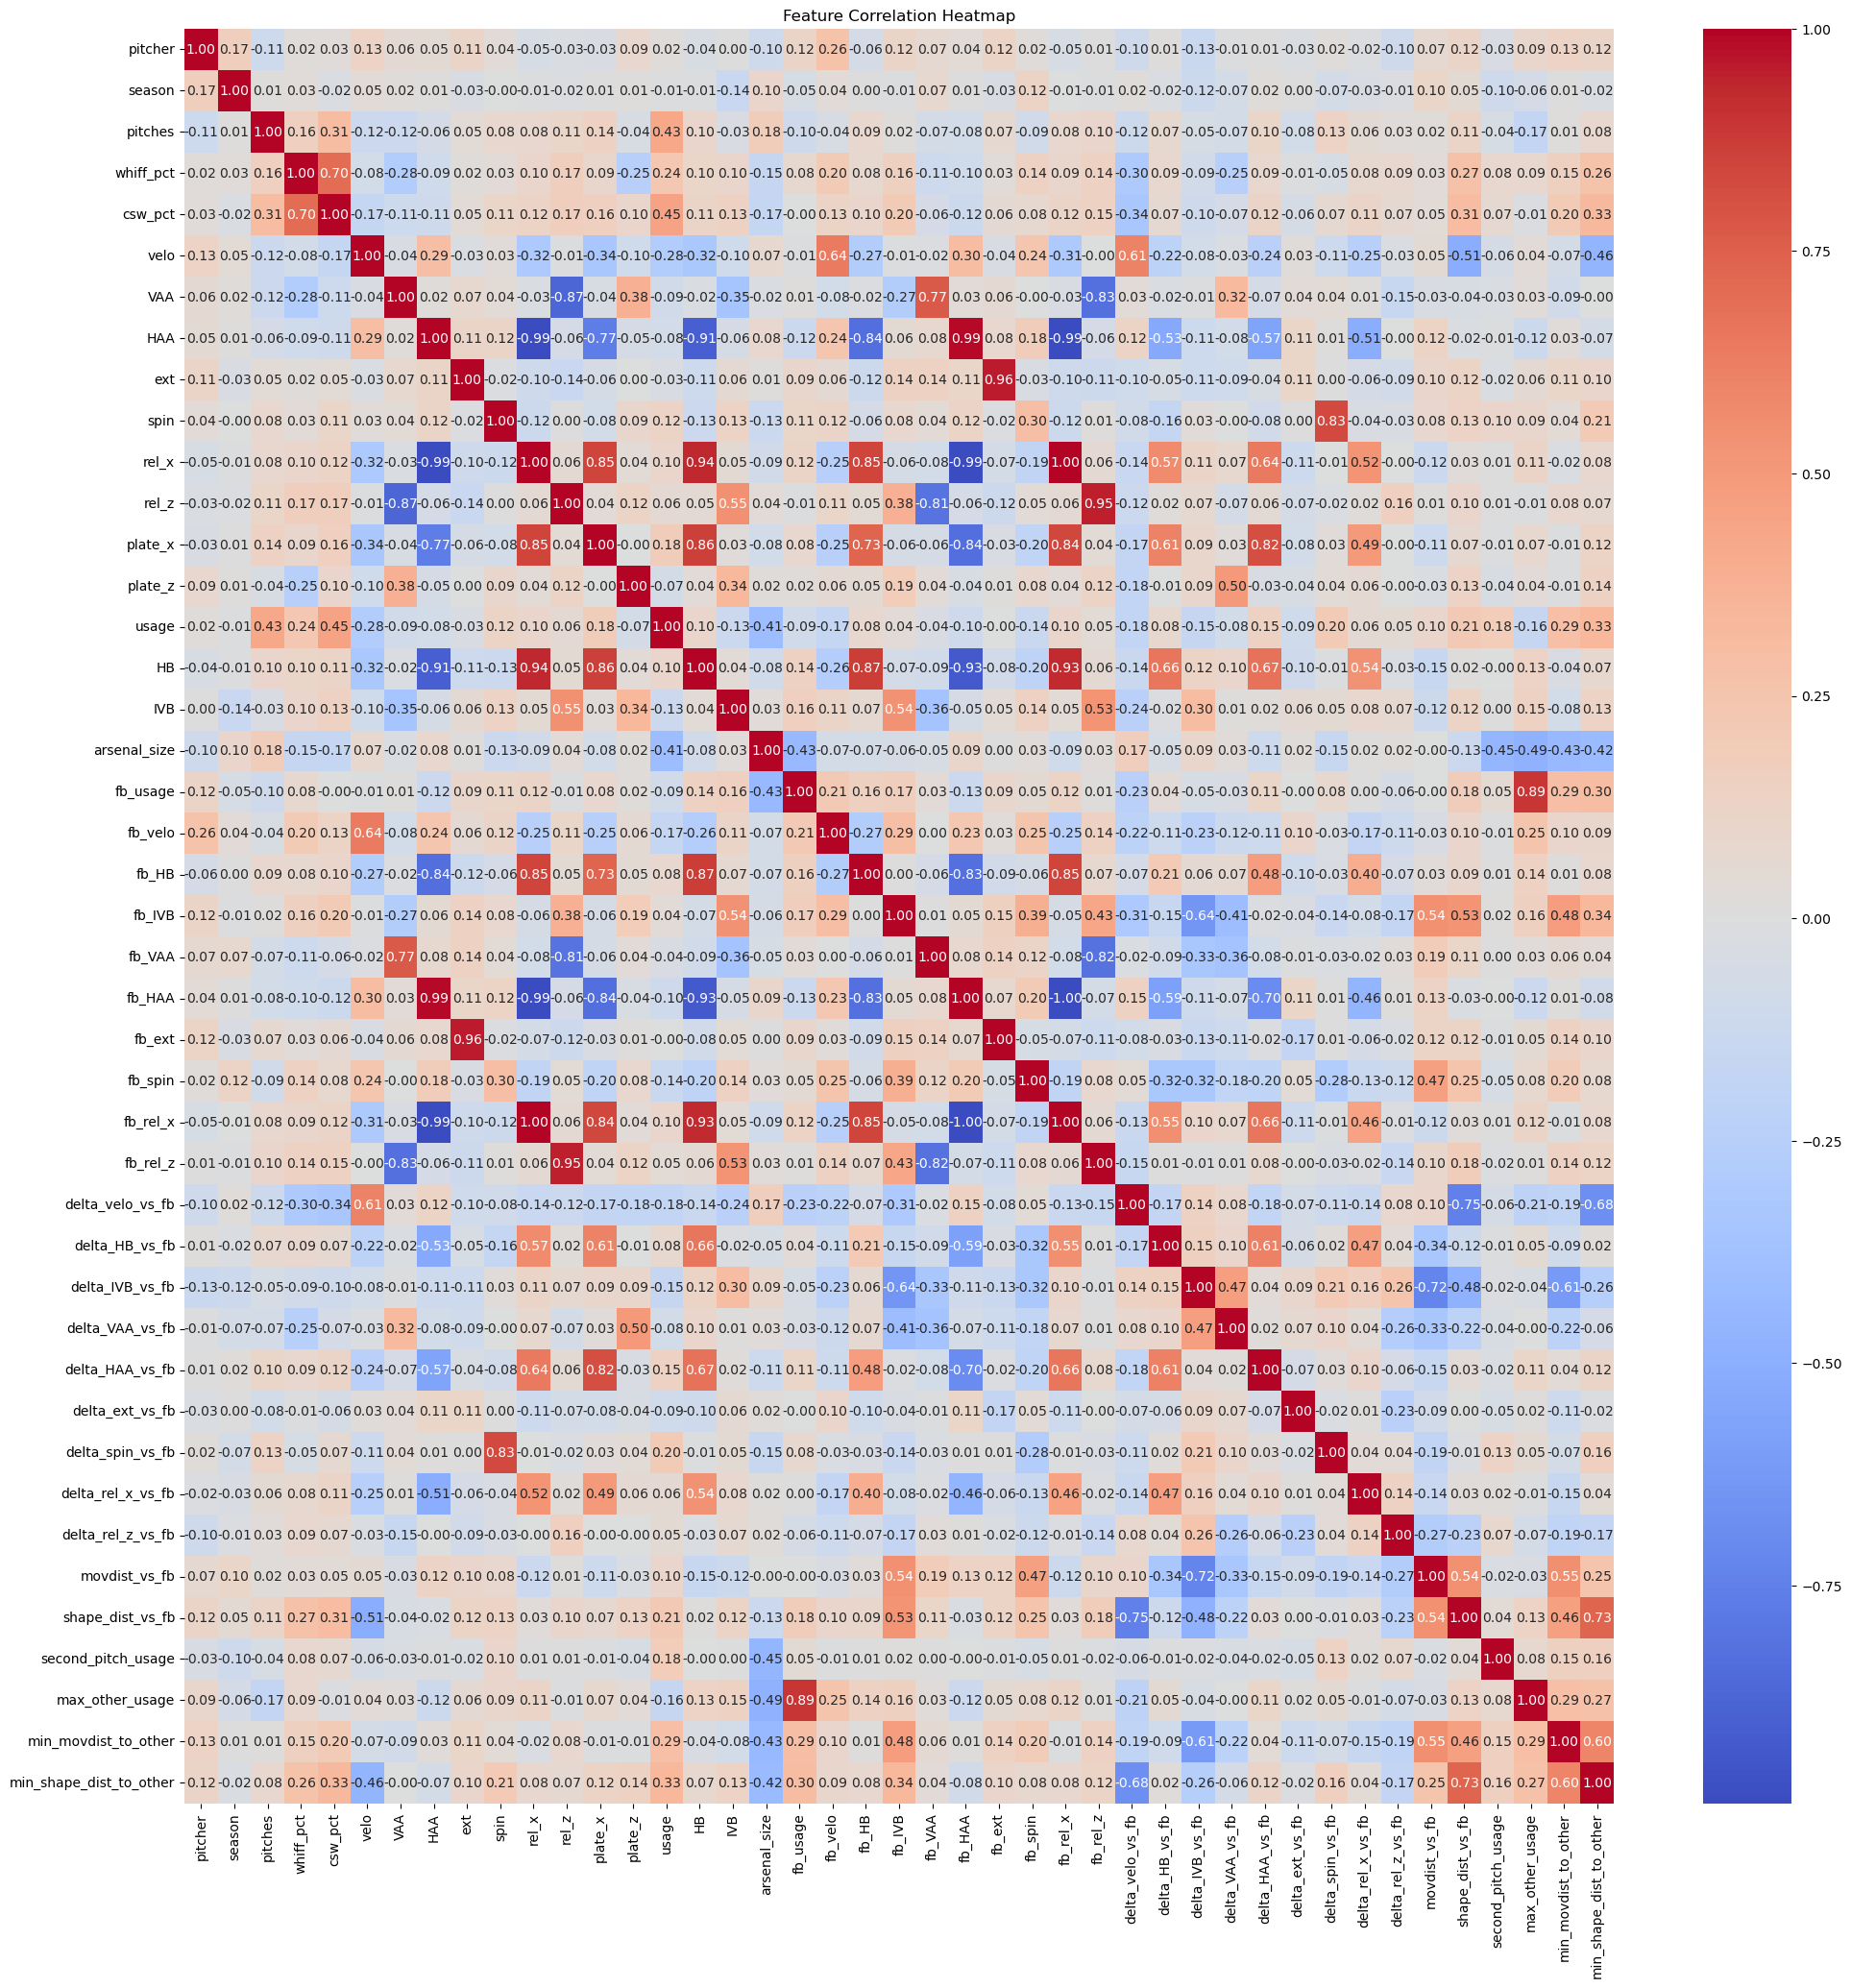

In [95]:
# create correlation heatmap for features with traget (whiff_pct)
import seaborn as sns
corr = ff_df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(24, 24))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

In [96]:
# develop base xgboost workflow 
cat_cols = ['p_throws', 'fb_pitch_type']

target = "whiff_pct"

# 1) train/val split by pitcher - when we have multiple seasons with same pitches
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(ff_df, groups=ff_df["pitcher"]))

train = ff_df.iloc[train_idx].copy()
val   = ff_df.iloc[val_idx].copy()

# 2) choose features (exclude ids + targets)
drop_cols = ["pitcher", "season", "pitch_type", "whiff_pct", "csw_pct"]
X_train = train.drop(columns=[c for c in drop_cols if c in train.columns])
X_val   = val.drop(columns=[c for c in drop_cols if c in val.columns])

y_train = train[target].values
y_val   = val[target].values

# 3) one-hot categorical cols (simple + reliable)
X_train = pd.get_dummies(X_train, columns=cat_cols, dummy_na=True)
X_val   = pd.get_dummies(X_val, columns=cat_cols, dummy_na=True)

# align columns
X_train, X_val = X_train.align(X_val, join="left", axis=1, fill_value=0)

# 4) sample weights to reflect stability of rate targets
w_train = train["pitches"].values  # or np.sqrt(train["pitches"].values)

model = XGBRegressor(
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    min_child_weight=5,
    objective="reg:squarederror",
    random_state=42
)

model.fit(X_train, y_train, sample_weight=w_train)

pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, pred))
r2 = r2_score(y_val, pred)

print("RMSE:", rmse, "R2:", r2)

RMSE: 0.09375718701576459 R2: 0.21713952887763543


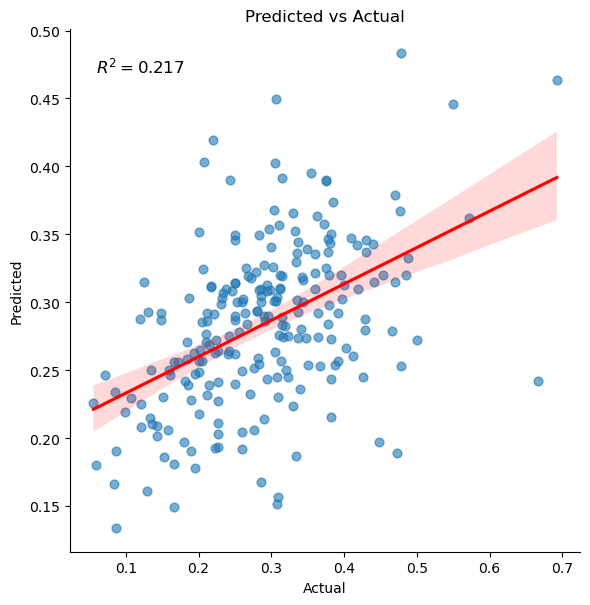

In [97]:
# seaborn lmplot of predicted vs actual
# Build plotting dataframe
plot_df = pd.DataFrame({
    "actual": y_val,
    "predicted": pred
})

# Plot
g = sns.lmplot(
    data=plot_df,
    x="actual",
    y="predicted",
    height=6,
    aspect=1,
    scatter_kws={"alpha": 0.6, "s": 40},
    line_kws={"color": "red"}
)

# Annotate R^2
plt.text(
    0.05, 0.95,
    f"$R^2 = {r2:.3f}$",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment="top"
)

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")

plt.show()



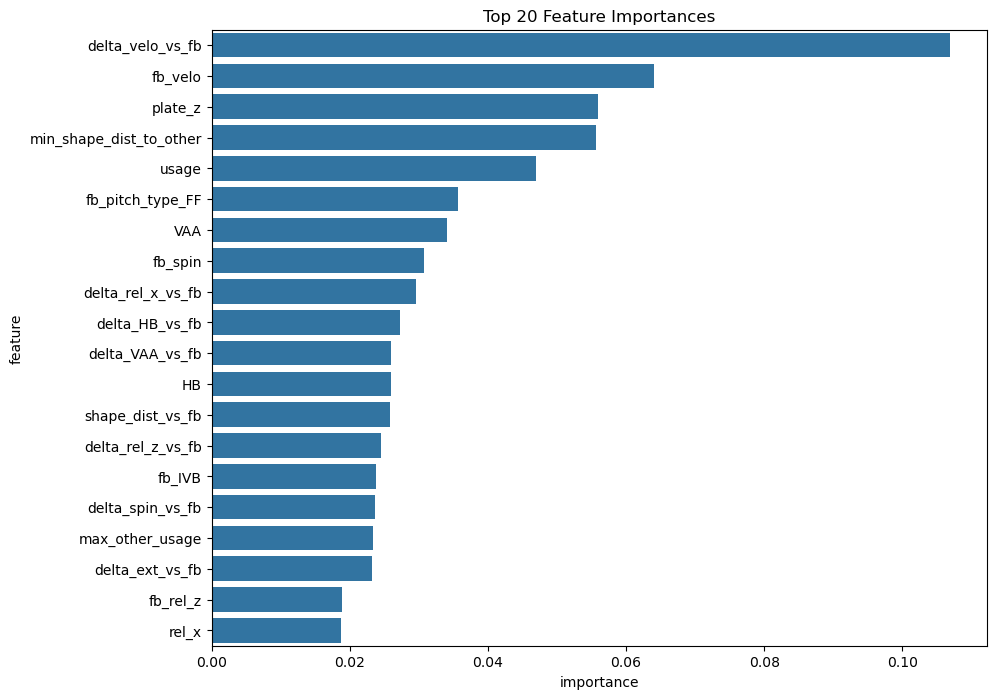

In [98]:
# plot feature importance
importances = model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importance_df.head(20))
plt.title("Top 20 Feature Importances")
plt.show()

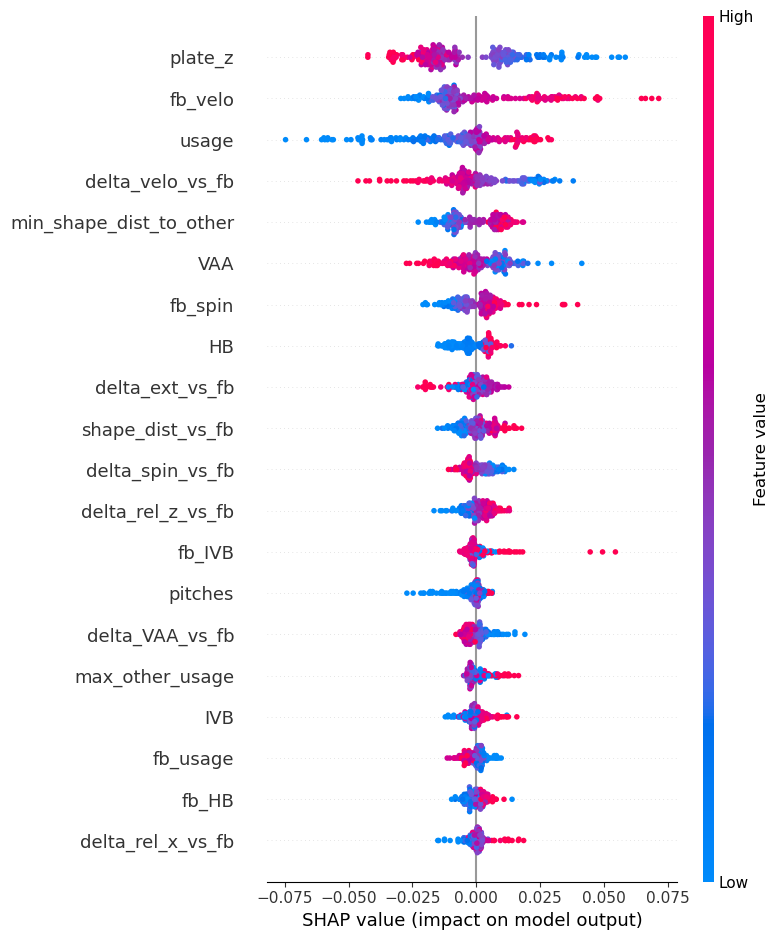

In [99]:
# shap explainer and summary plot
explainer = shap.Explainer(model)
shap_values = explainer(X_val)
shap.summary_plot(shap_values, X_val)